In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

import dynesty
from dynesty import plotting as dyplot # dynesty plots

In [2]:
# Expected flux as a function of time
def model_flux(t, t0, b, A, alpha):
    if t < t0:
        return b
    else:
        return b + A * np.exp(-alpha * (t - t0))

In [3]:
# transient[measurment_index][quantity_index], quantity_index = (0, 1, 2): (time, flux, flux_err)
transient = np.load("transient.npy")

N = len(transient)

# transient[quantity_index][measurment_index]
transient = np.swapaxes(transient, 0, 1)

time_data = transient[0]
flux_data = transient[1]
flux_err_data = transient[2]

# Errors are homoschedastic
sigma = flux_err_data[0]

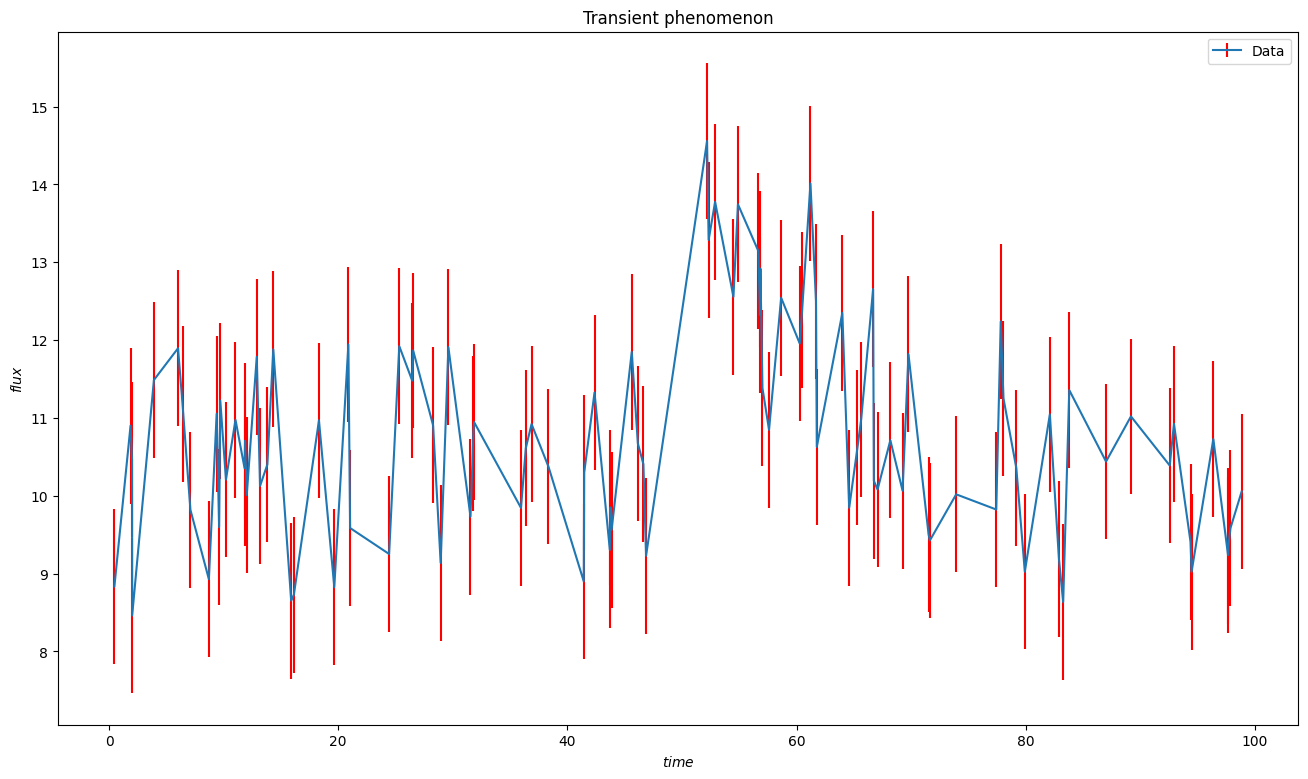

In [4]:
# Plot the data
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')

ax.legend()

plt.show()

In [5]:
# Model by eye
t0 = 50
b = 10
A = 5
alpha = 0.1

grid_n_points = 1000

time_grid = np.linspace(np.min(time_data), np.max(time_data), grid_n_points)

flux_model = np.array([model_flux(t, t0, b, A, alpha) for t in time_grid])

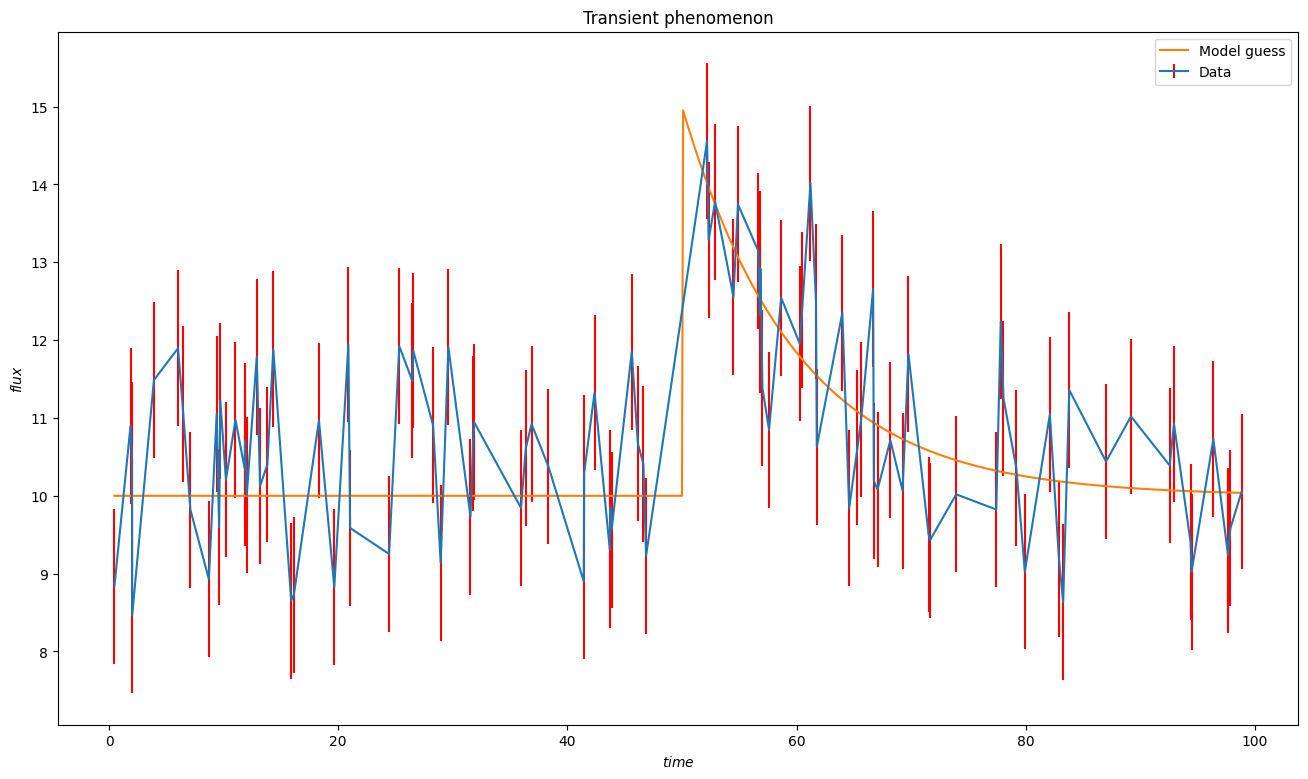

In [6]:
# Plot the guess for the model along with the data
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')
ax.plot(time_grid, flux_model, label='Model guess')

ax.legend()

plt.show()

In [8]:
# Define the keys for parameters of the posterior
par_keys = ['A', 'b', 'log_alpha', 't0']

# Associate indexes with a dictionary
par_indexes = dict(zip(par_keys, range(len(par_keys))))

# Labels and styles for the parameters
par_labels = []
par_u_labels = []
par_colors = []

# Make the parameters labels
for key in par_keys:
    if key == 't0':
        par_labels.append(r'$t_0$')
        par_u_labels.append(r'$time$')
        par_colors.append('lime')
    elif key == 'b':
        par_labels.append(r'$b$')
        par_u_labels.append(r'$flux$')
        par_colors.append('orange')
    elif key == 'A':
        par_labels.append(r'$A$')
        par_u_labels.append(r'$flux$')
        par_colors.append('royalblue')
    elif key == 'log_alpha':
        par_labels.append(r'$\log(\alpha)$')
        par_u_labels.append(r'$\log(1/time)$')
        par_colors.append('rosybrown')

In [9]:
# Define the quantiles to be used for the results
quantiles = [0.05, 0.5, 0.95]

In [10]:
# Number of dimension of the problem
ndim = 4

# Define our uniform prior via the prior transform.
# u is the unit hypercube from which parameters are initially sampled
def ptform(u):
    x = np.array(u)

    # Choosing a wider parameter space leads to longer sampling times
    # It is better to choose a small prior
    x[par_indexes['t0']] = stats.uniform.ppf(u[par_indexes['t0']], 40, 60)
    x[par_indexes['b']] = stats.uniform.ppf(u[par_indexes['b']], 0, 20)
    x[par_indexes['A']] = stats.uniform.ppf(u[par_indexes['A']], 0, 20)
    x[par_indexes['log_alpha']] = stats.uniform.ppf(u[par_indexes['log_alpha']], -5, 5)

    return x

# The loglikelihood of the data given the (sampled) model
# x is an array of the parameters of the model as transformed by ptform()
def loglike(x):
    t0 = x[par_indexes['t0']]
    b = x[par_indexes['b']]
    A = x[par_indexes['A']]
    log_alpha = x[par_indexes['log_alpha']]

    # Compute the expected flux with the model given by x at every time
    expected_flux = np.array([model_flux(t, t0, b, A, np.exp(log_alpha)) for t in time_data])

    # Compute the loglikelihood of the data assuming a normal distribution around the model
    logL = 0
    for i in range(N):
        logL += np.log(stats.norm.pdf(flux_data[i], expected_flux[i], sigma))
    
    return logL

In [11]:
# Initialize the sampler
sampler = dynesty.NestedSampler(loglike, ptform, ndim)

In [12]:
# Sample using nested sampling
sampler.run_nested()

6239it [11:20,  9.17it/s, +500 | bound: 44 | nc: 1 | ncall: 51517 | eff(%): 13.209 | loglstar:   -inf < -140.662 <    inf | logz: -152.347 +/-  0.150 | dlogz:  0.001 >  0.509]


In [62]:
# Explore the result
sresults = sampler.results

sresults

         nlive: 500
         niter: 6239
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 13.209322382735166
       samples: array([[19.92741455, 18.18460374, -4.50043769, 43.85843475],
       [19.17525166, 18.13103345, -4.72966409, 48.70316045],
       [19.25734089, 16.15924996, -4.61147758, 42.30483766],
       ...,
       [ 4.87625154, 10.26788523, -2.14949622, 49.95573856],
       [ 7.13659424, 10.27863103, -2.10158347, 47.1938292 ],
       [ 5.17561827, 10.28194595, -2.13302667, 49.44265345]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([122, 143, 248, ..., 138, 415, 390])
    samples_it: array([   0,    0,    0, ..., 6104, 3339, 6128])
     samples_u: array([[0.99637073, 0.90923019, 0.09991246, 0.06430725],
       [0.95876258, 0.90655167, 0.05406718, 0.14505267],
       [0.96286704, 0.8079625 , 0.07770448, 0.03841396],
       ...,
       [0.24381258, 0.51339426, 0.57010076, 0.16592898],
       [0.35682971, 0.5

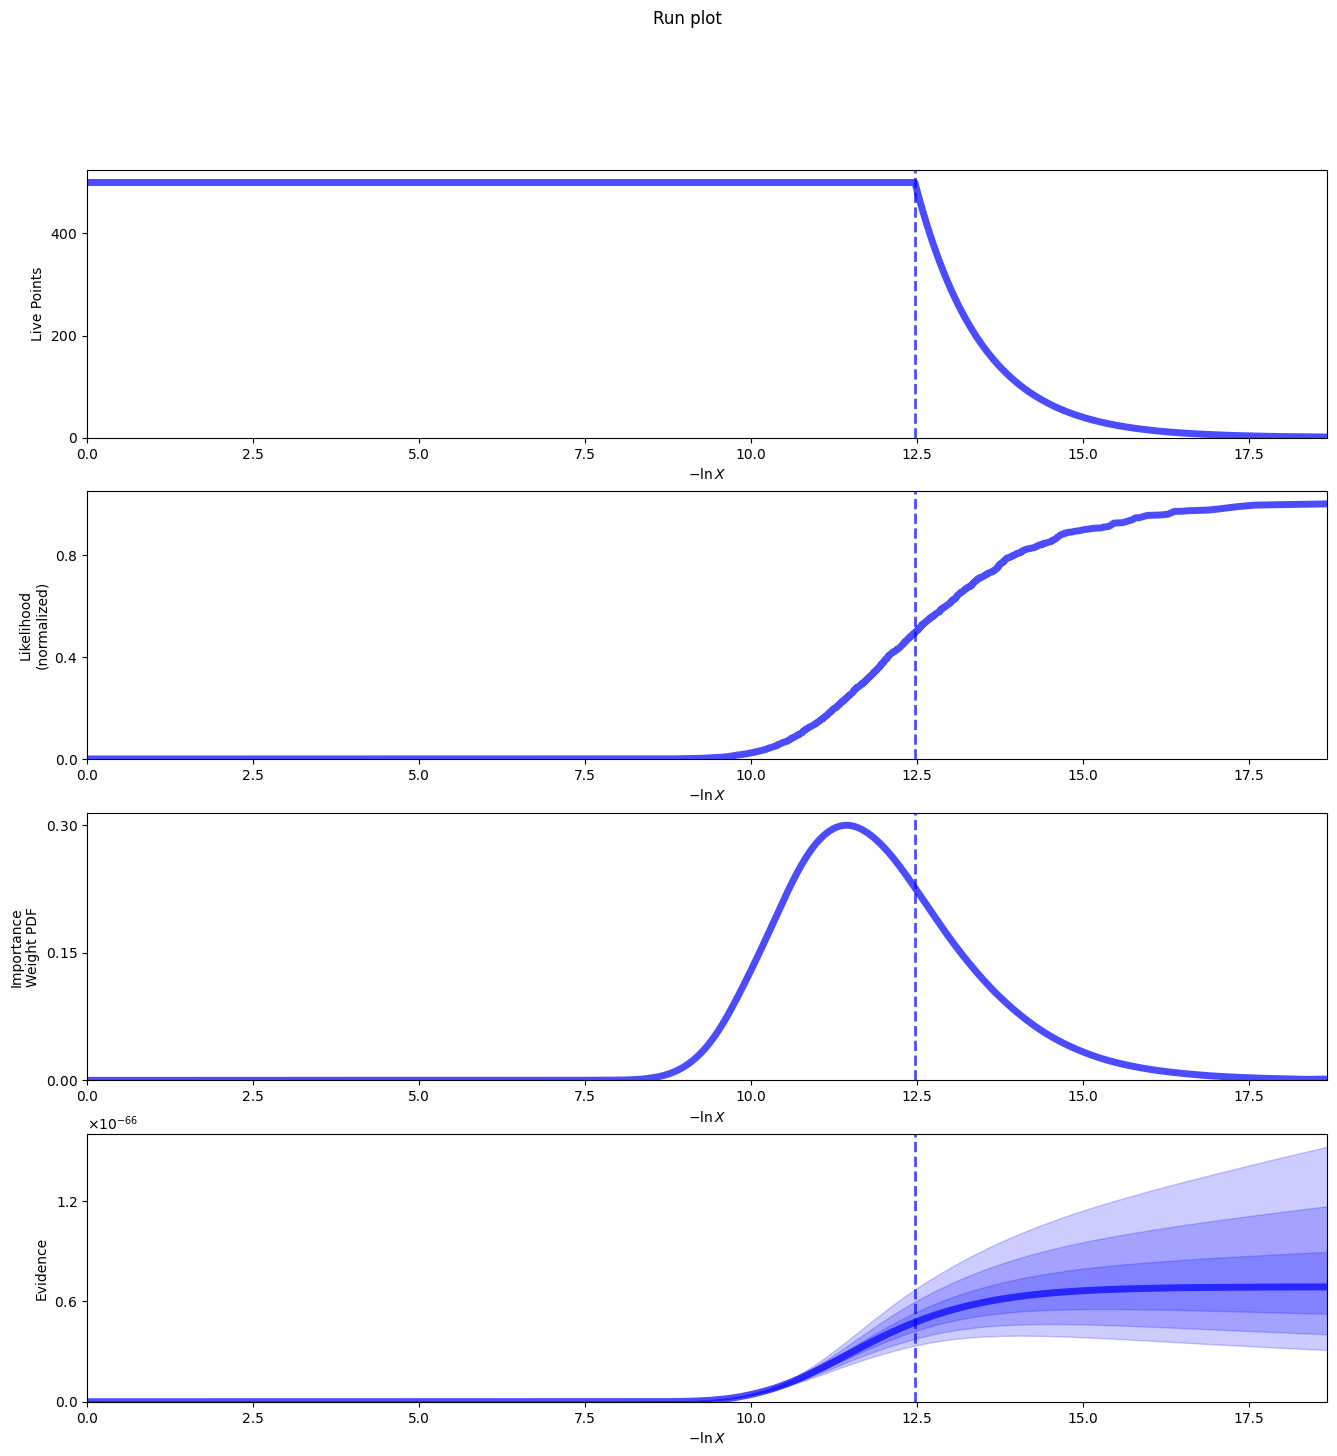

In [63]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

rfig.suptitle("Run plot")

plt.show()

# Note

Be aware of the fact that samples in nested **sampling** by *dynesty* are **_weighted_**, therfore using plotting functions from different libraries (e.g. ArviZ) would result in wrong quantiles computations.

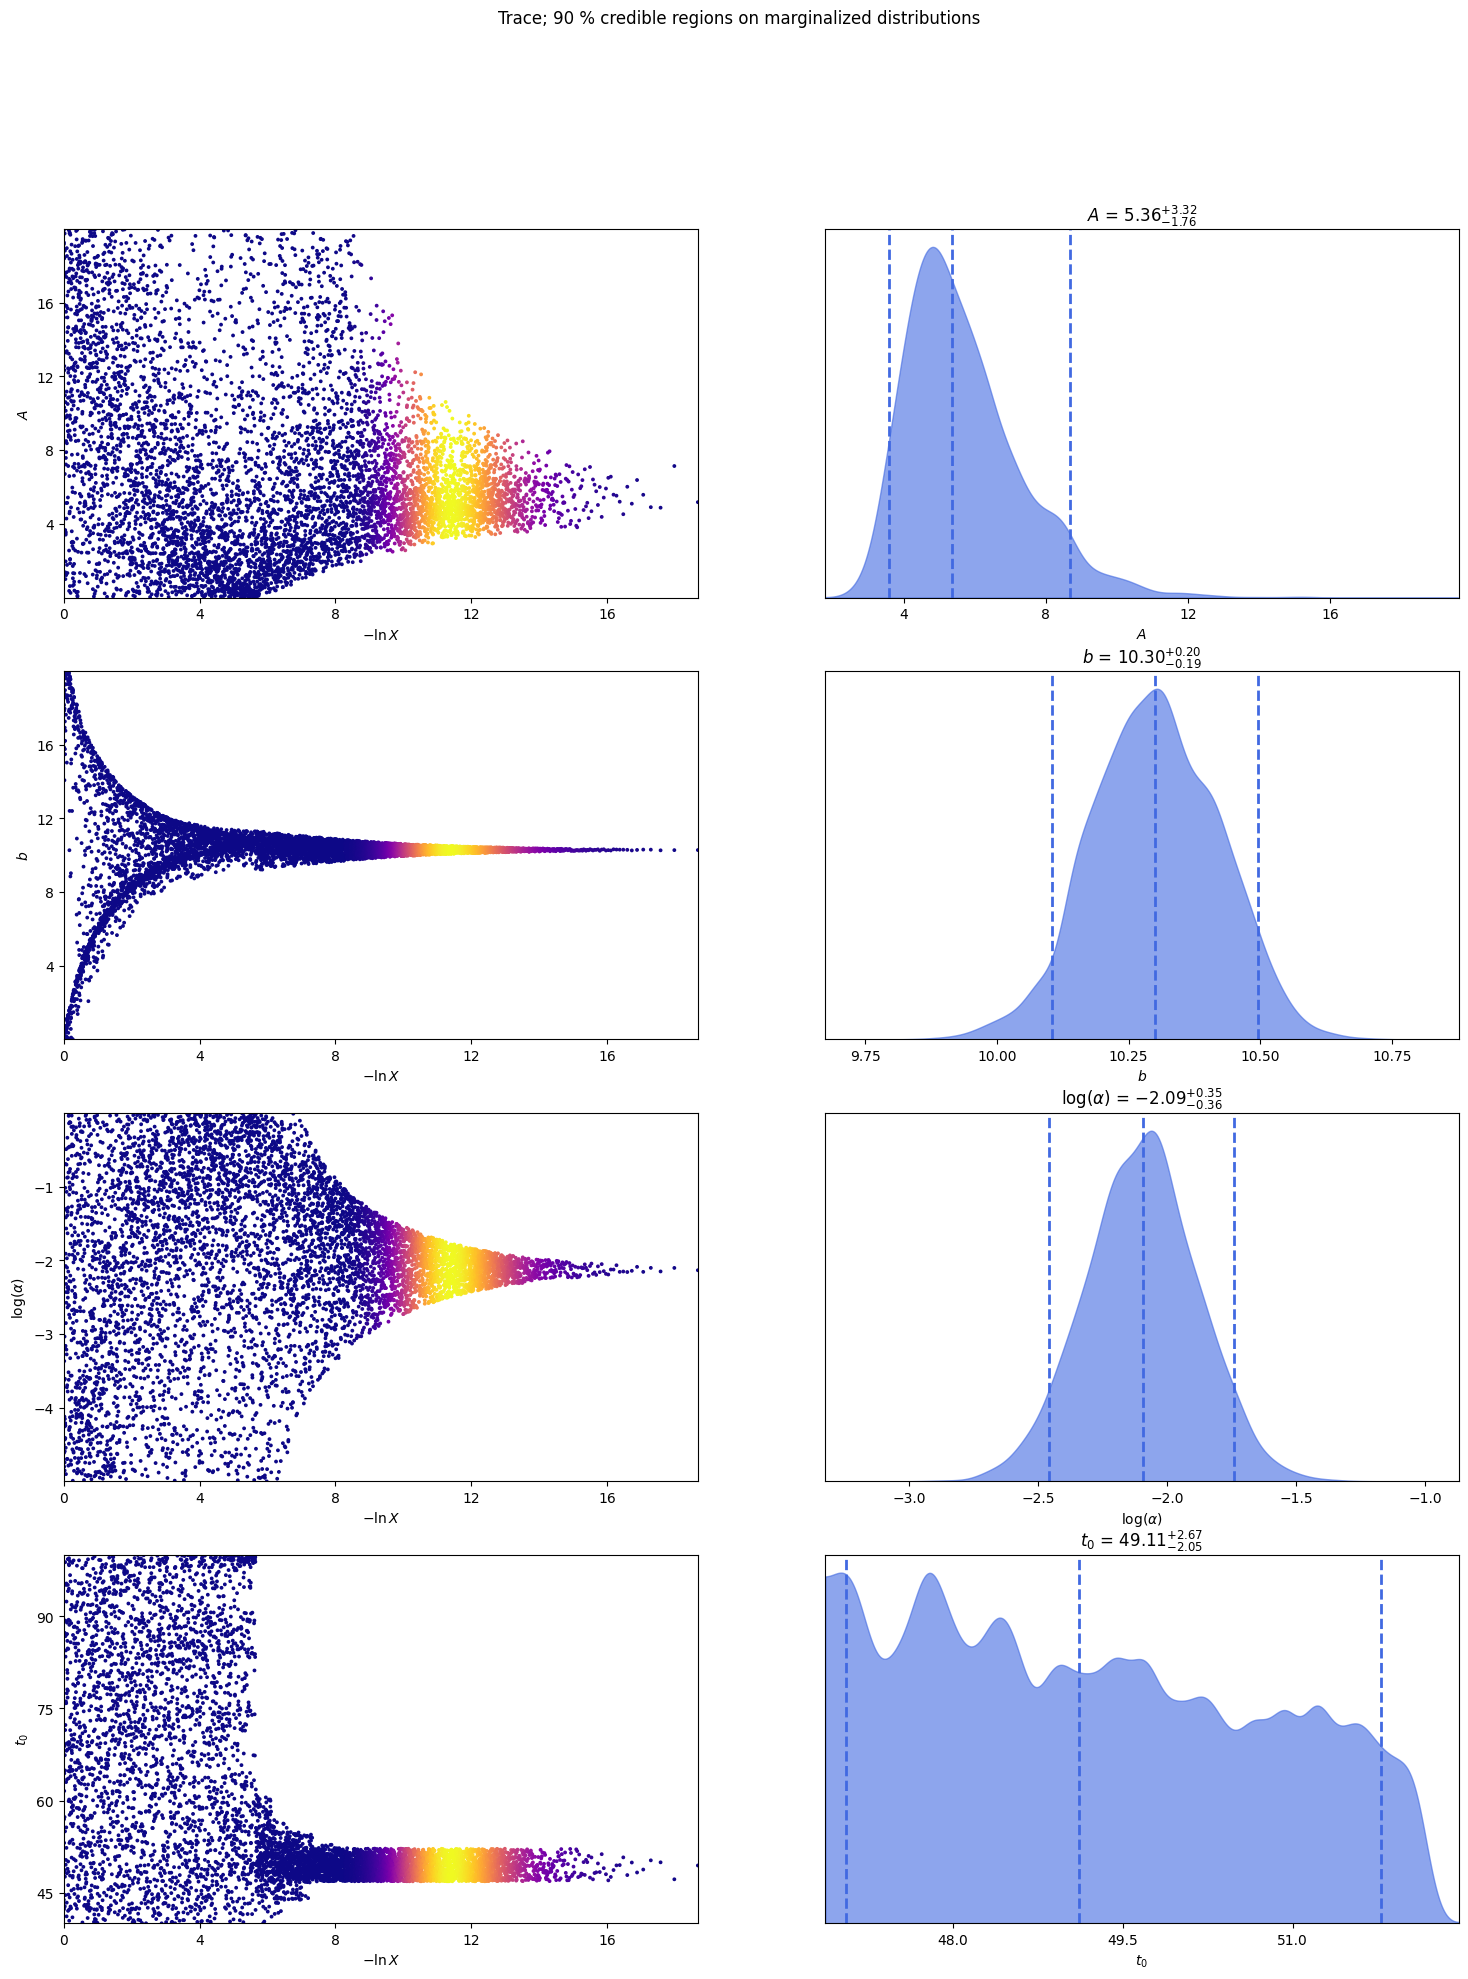

In [64]:
# Trace plot
tfig, taxes = dyplot.traceplot(sresults,
                               labels=par_labels,
                               show_titles=True,
                               quantiles=quantiles,
                               title_quantiles=quantiles,
                               post_color='royalblue')

tfig.set_size_inches(18, 22)
tfig.suptitle("Trace; 90 % credible regions on marginalized distributions")

plt.show()

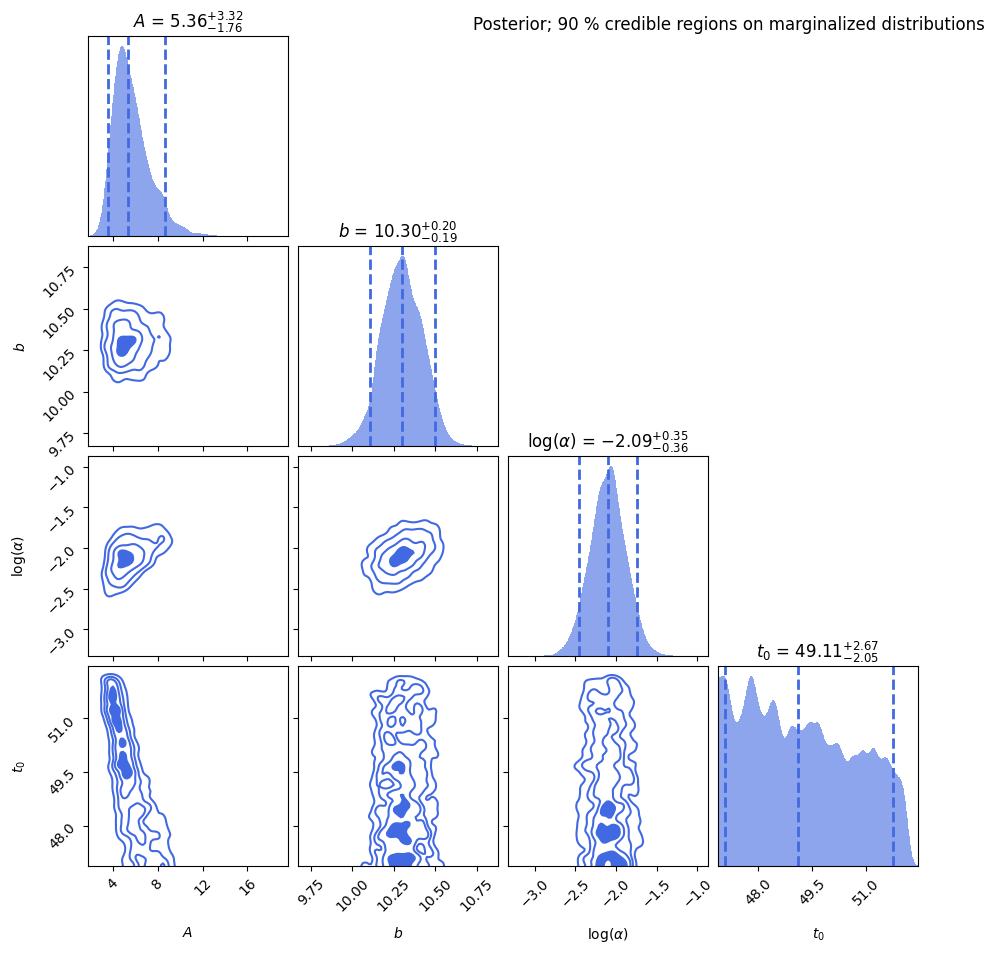

In [65]:
# Corner plot
cfig, caxes = dyplot.cornerplot(sresults,
                                labels=par_labels,
                                show_titles=True,
                                color='royalblue',
                                quantiles=quantiles,
                                title_quantiles=quantiles)

cfig.suptitle("Posterior; 90 % credible regions on marginalized distributions", horizontalalignment='left')

plt.show()

In [66]:
# Burn index of the chain
burn_index = 4000

# sresults works like this: sresults[sample_index][par_index]
# par_pos[par_index][sample_index]
par_pos = np.swapaxes(sresults['samples'][burn_index:], 0, 1)

In [67]:
# Styles for the quantiles
quantile_styles = [':', '-.', '--']
quantile_colors = ['magenta', 'red', 'magenta']
quantile_labels = ['5 % quantile', r'$\mu$', '95 % quantile']

# Save the quantiles of the parameters
par_quantiles = []

# Weights of each sample
sample_weights = sresults.importance_weights()[burn_index:]

# 90 % credible regions
for key in par_keys:
    par_quantiles.append(dynesty.utils.quantile(par_pos[par_indexes[key]], [0.05, 0.5, 0.95], sample_weights))

par_quantiles = np.array(par_quantiles)

# Construct the result for every parameter using the quantiles
par_values_str = []

for key in par_keys:
    l_ = np.format_float_positional(par_quantiles[par_indexes[key]][1] - par_quantiles[par_indexes[key]][0], 2)
    mu = np.format_float_positional(par_quantiles[par_indexes[key]][1], 2)
    _r = np.format_float_positional(par_quantiles[par_indexes[key]][2] - par_quantiles[par_indexes[key]][1], 2)

    # To escape the '{' and the '}' you have to use {{ and }}
    par_values_str.append(r'${mu}^{{+{_r}}}_{{-{l_}}}$'.format(mu=mu, _r=_r, l_=l_))

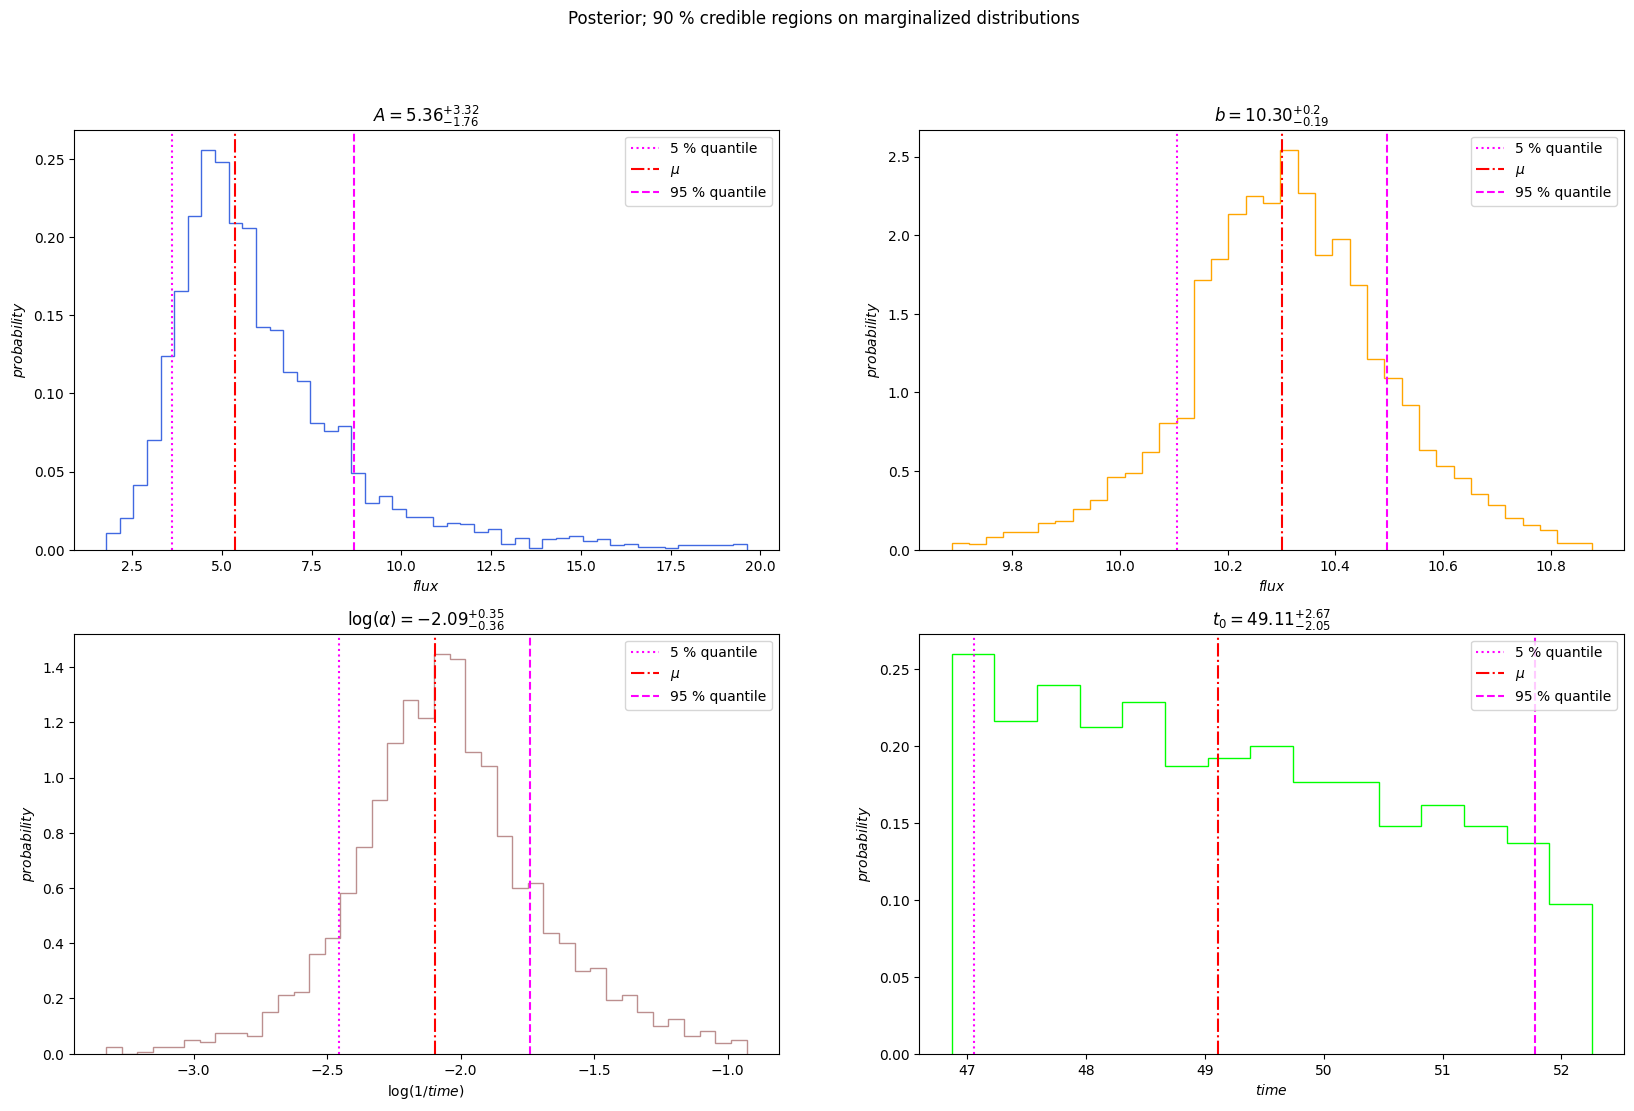

In [68]:
# Plot just the marginalized distributions with 90 % credible regions
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,12))

fig.suptitle("Posterior; 90 % credible regions on marginalized distributions")

index = 0
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].set_title(par_labels[index] + '$=$' + par_values_str[index])
        ax[i][j].set_xlabel(par_u_labels[index])
        ax[i][j].set_ylabel(r'$probability$')

        ax[i][j].hist(par_pos[index],
                      bins='auto',
                      density=True,
                      color=par_colors[index],
                      histtype='step')
        
        # Quantile lines plotting
        for k in range(len(par_quantiles[index])):
            ax[i][j].axvline(par_quantiles[index][k],
                             color=quantile_colors[k],
                             ls=quantile_styles[k],
                             label=quantile_labels[k])

        ax[i][j].legend()
        
        index += 1

plt.show()

In [69]:
# Select 100 random samples
rnd_samples = sresults['samples'][burn_index:][np.random.randint(0, len(sresults['samples'][burn_index:]), 100)]

models = np.array([[model_flux(t,
                               rnd_samples[i][par_indexes['t0']],
                               rnd_samples[i][par_indexes['b']],
                               rnd_samples[i][par_indexes['A']],
                               np.exp(rnd_samples[i][par_indexes['log_alpha']]))
                               for t in time_grid]
                               for i in range(len(rnd_samples))])

# Build the bast model
best_model = np.array([model_flux(t,
                                  par_quantiles[par_indexes['t0']][1],
                                  par_quantiles[par_indexes['b']][1],
                                  par_quantiles[par_indexes['A']][1],
                                  np.exp(par_quantiles[par_indexes['log_alpha']][1]))
                                  for t in time_grid])

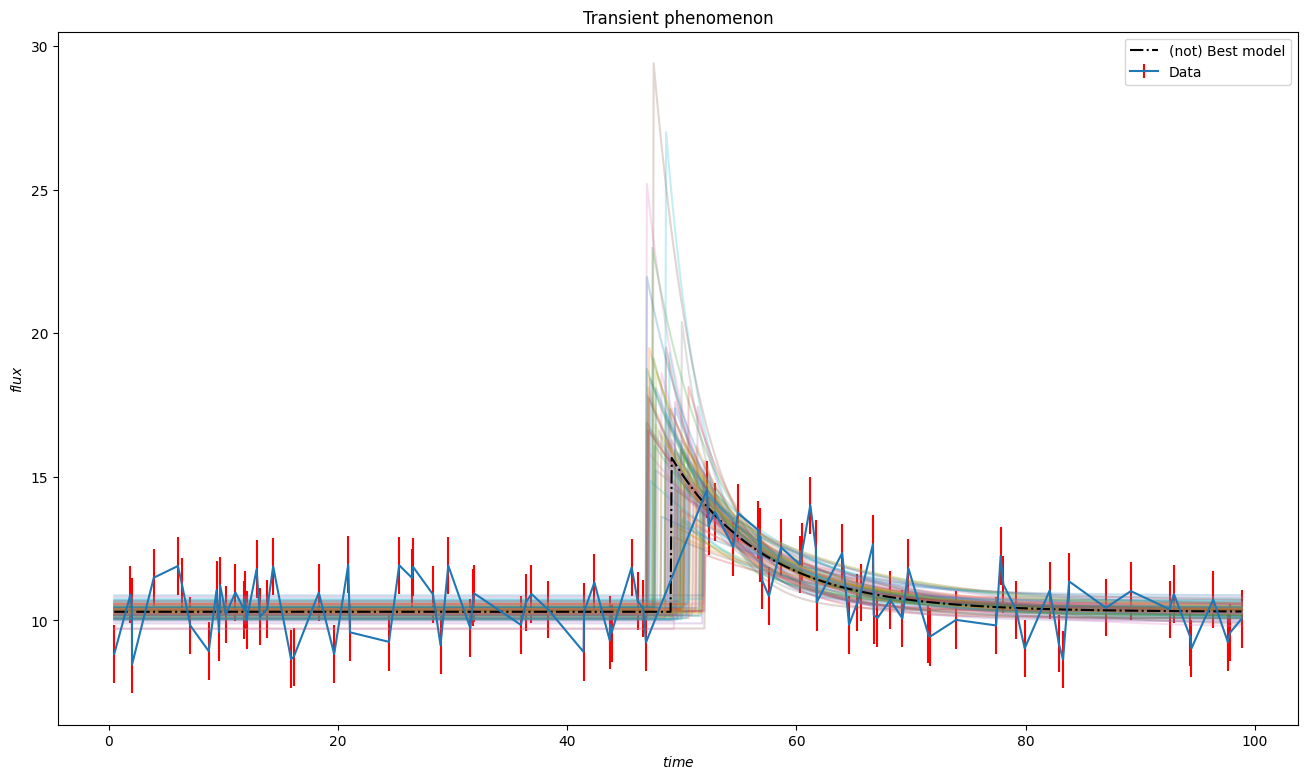

In [70]:
# Plot the models from the randomly selected samples
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Transient phenomenon")
ax.set_xlabel("$time$")
ax.set_ylabel("$flux$")

ax.errorbar(time_data, flux_data, yerr=flux_err_data, ecolor='red', label='Data')

# Random selected models
for i in range(len(models)):
    ax.plot(time_grid, models[i], alpha=0.25) # alpha is to set the opacity

# Best model
ax.plot(time_grid, best_model, color='black', label='(not) Best model', ls='-.')

ax.legend()

plt.show()